In [1]:
import subprocess
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_code_regular(n_bits,n_checks,n_ones_columns,seed,construction,prefix):
    # create parity check matrix
    if construction == "library":
        # use LDPC-codes library 
        !../LDPC-codes/make-ldpc {prefix}.pchk {n_checks} {n_bits} 1 evenboth {n_ones_columns} no4cycle
    else:
        subprocess.run("python3 ../LDPC-library/make-pchk.py " + \
                       "--output-pchk-file "+ prefix + ".pchk " + \
                       "--code-type regular " +
                       "--construction "+ construction + " " + \
                       "--n-checks " + str(n_checks) + " " + \
                       "--n-bits " + str(n_bits) + " " + \
                       "--checks-per-col " + str(n_ones_columns) + " " + \
                       "--seed " + str(seed), shell=True)
    # create generator matrix
    !../LDPC-codes/make-gen {prefix}.pchk {prefix}.gen sparse
    return

def generate_code_protograph(protograph_file,expansion_factor,seed,construction,prefix):
    # create parity check matrix
    subprocess.run("python3 ../LDPC-library/make-pchk.py " + \
                   "--output-pchk-file "+ prefix + ".pchk " + \
                   "--code-type protograph " +
                   "--construction "+ construction + " " + \
                   "--protograph-file " + str(protograph_file) + " " + \
                   "--expansion-factor " + str(expansion_factor) + " " + \
                   "--seed " + str(seed), shell=True)
    # create generator matrix
    !../LDPC-codes/make-gen {prefix}.pchk {prefix}.gen sparse
    return

def run_exp_single_snr(prefix,snr,seed):
    sd = compute_standard_deviation_from_snr_db(snr)
    !../LDPC-codes/transmit {prefix}.encoded {prefix}.received $seed awgn $sd
    subprocess.run("python3 ../LDPC-library/decode.py " + \
                   "--pchk-file "+ prefix + ".pchk " + \
                   "--received-file "+ prefix + ".received " + \
                   "--output-file "+ prefix + ".decoded " + \
                   "--channel awgn " + \
                   "--channel-parameters " + str(sd), shell=True)
    return compute_ber_fer(prefix)

def run_exp_snr_list(prefix,snr_list,seed):
    results_list = [] # list of tuples (snr,ber,fer)
    for snr in snr_list:
        ber,fer = run_exp_single_snr(prefix,snr,seed)
        results_list.append((snr,ber,fer))
        if ber == 0.0:
            break # after this it will always be zero
    return results_list

def generate_source(prefix,msg_len,n_blocks,seed):
    !../LDPC-codes/rand-src {prefix}.message $seed {msg_len}x{n_blocks}

def perform_encoding(prefix,seed):
    subprocess.run("python3 ../LDPC-library/encode.py " + \
                   "--pchk-file "+ prefix + ".pchk " + \
                   "--gen-file "+ prefix + ".gen " + \
                   "--input-file "+ prefix + ".message " + \
                   "--output-file "+ prefix + ".encoded", shell=True)
    
def compute_ber_fer(prefix):
    encoded_file = prefix+".encoded"
    decoded_file = prefix+".decoded"

    with open(encoded_file) as f:
        encoded_codewords = [l.rstrip('\n') for l in f.readlines()]

    with open(decoded_file) as f:
        decoded_codewords = [l.rstrip('\n') for l in f.readlines()]

    assert len(encoded_codewords) == len(decoded_codewords)
    for i in range(len(encoded_codewords)):
        assert len(encoded_codewords[i]) == len(decoded_codewords[i])

    print('Number of codewords:', len(decoded_codewords))
    bit_errors_total = 0
    block_errors_total = 0
    total_length = 0
    for encoded_codeword, decoded_codeword in zip(encoded_codewords,decoded_codewords):
        bit_errors = sum([encoded_codeword[i] != decoded_codeword[i] for i in range(len(decoded_codeword))])
        if bit_errors != 0:
            block_errors_total += 1
        bit_errors_total += bit_errors
        total_length += len(decoded_codeword)

    ber = (bit_errors_total/total_length)
    fer = (block_errors_total/len(decoded_codewords))
    return ber,fer

def write_results_to_file(results,log_file_name):
    with open(log_file_name,'w') as f:
        f.write("SNR,BER,FER\n")
        for result in results:
            f.write(','.join([str(val) for val in result])+'\n')
            
def read_snr_ber_from_file(log_file_name):
    with open(log_file_name) as f:
        data = [l.rstrip('\n').split(',') for l in f.readlines()]
    snr = [float(d[0]) for d in data[1:]]
    ber = [float(d[1]) for d in data[1:]]
    return snr,ber
    
def compute_standard_deviation_from_snr_db(snr):
    return math.pow(10,-snr/20)

def cleanup(prefix):
    !rm {prefix}.*

In [19]:
snr_list = np.arange(0.0,4.0,0.05)

In [20]:
prefix = "tmptmp"
n_bits = 2000
n_checks = 1000 # rate 1/2
msg_len = n_bits - n_checks
n_ones_columns = 3
seed = 42345
n_blocks = 5000

In [ ]:
for construction in ["peg","library"]:
    generate_source(prefix,msg_len,n_blocks,seed)
    generate_code_regular(n_bits,n_checks,n_ones_columns,seed,construction,prefix)
    perform_encoding(prefix,seed)
    results = run_exp_snr_list(prefix,snr_list,seed)
    log_file_name = "data/regular_"+construction+"_"+str(n_bits)+"_"+str(n_checks)+"_"+str(n_ones_columns)
    write_results_to_file(results,log_file_name)
    cleanup(prefix)

In [22]:
snr_list = np.arange(1.0,5.0,0.05)
prefix = "tmptmp"
n_bits = 2000
n_checks = 666 # rate 2/3
msg_len = n_bits - n_checks
n_ones_columns = 3
seed = 42345
n_blocks = 5000

In [ ]:
for construction in ["peg","library"]:
    generate_source(prefix,msg_len,n_blocks,seed)
    generate_code_regular(n_bits,n_checks,n_ones_columns,seed,construction,prefix)
    perform_encoding(prefix,seed)
    results = run_exp_snr_list(prefix,snr_list,seed)
    log_file_name = "data/regular_"+construction+"_"+str(n_bits)+"_"+str(n_checks)+"_"+str(n_ones_columns)
    write_results_to_file(results,log_file_name)
    cleanup(prefix)

In [ ]:
snr_list = np.arange(0.0,4.0,0.05)
prefix = "tmptmp"
protograph_file = "../sample-protographs/ar4ja_n_0_rate_1_2"
expansion_factor = 500
msg_len = expansion_factor*2
seed = 42345
n_blocks = 5000
for construction in ["peg","quasi-cyclic","permuted-quasi-cyclic","sum-permutations","regular"]:
    generate_source(prefix,msg_len,n_blocks,seed)
    generate_code_protograph(protograph_file,expansion_factor,seed,construction,prefix)
    perform_encoding(prefix,seed)
    results = run_exp_snr_list(prefix,snr_list,seed)
    log_file_name = "data/protograph_ar4ja_n_0_rate_1_2_"+construction+"_"+str(expansion_factor)
    write_results_to_file(results,log_file_name)
    cleanup(prefix)

In [ ]:
snr_list = np.arange(1.0,5.0,0.05)
prefix = "tmptmp"
protograph_file = "../sample-protographs/ar4ja_n_1_rate_2_3"
expansion_factor = 334
msg_len = expansion_factor*4
seed = 42345
n_blocks = 5000
for construction in ["peg","quasi-cyclic","permuted-quasi-cyclic","sum-permutations"]:
    generate_source(prefix,msg_len,n_blocks,seed)
    generate_code_protograph(protograph_file,expansion_factor,seed,construction,prefix)
    perform_encoding(prefix,seed)
    results = run_exp_snr_list(prefix,snr_list,seed)
    log_file_name = "data/protograph_ar4ja_n_1_rate_2_3_"+construction+"_"+str(expansion_factor)
    write_results_to_file(results,log_file_name)
    cleanup(prefix)

In [ ]:
snr_list = np.arange(0.0,4.0,0.05)
prefix = "tmptmp"
protograph_file = "../sample-protographs/ar3a_n_0_rate_1_2"
expansion_factor = 500
msg_len = expansion_factor*2
seed = 42345
n_blocks = 5000
for construction in ["peg","quasi-cyclic","permuted-quasi-cyclic","sum-permutations"]:
    generate_source(prefix,msg_len,n_blocks,seed)
    generate_code_protograph(protograph_file,expansion_factor,seed,construction,prefix)
    perform_encoding(prefix,seed)
    results = run_exp_snr_list(prefix,snr_list,seed)
    log_file_name = "data/protograph_ar3a_n_0_rate_1_2_"+construction+"_"+str(expansion_factor)
    write_results_to_file(results,log_file_name)
    cleanup(prefix)

In [ ]:
snr_list = np.arange(1.0,5.0,0.05)
prefix = "tmptmp"
protograph_file = "../sample-protographs/ar3a_n_1_rate_2_3"
expansion_factor = 334
msg_len = expansion_factor*4
seed = 42345
n_blocks = 5000
for construction in ["peg","quasi-cyclic","permuted-quasi-cyclic","sum-permutations"]:
    generate_source(prefix,msg_len,n_blocks,seed)
    generate_code_protograph(protograph_file,expansion_factor,seed,construction,prefix)
    perform_encoding(prefix,seed)
    results = run_exp_snr_list(prefix,snr_list,seed)
    log_file_name = "data/protograph_ar3a_n_1_rate_2_3_"+construction+"_"+str(expansion_factor)
    write_results_to_file(results,log_file_name)
    cleanup(prefix)

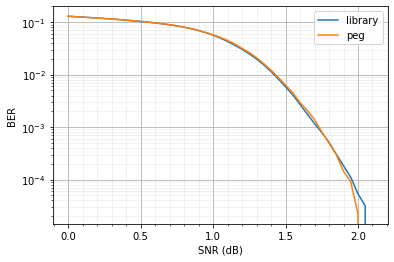

In [3]:
# regular rate 1/2 different construction methods
snr_library, ber_library = read_snr_ber_from_file("data/regular_library_2000_1000_3")
snr_peg, ber_peg = read_snr_ber_from_file("data/regular_peg_2000_1000_3")

plt.plot(snr_library, ber_library)
plt.plot(snr_peg, ber_peg)
plt.legend(['library','peg'])
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(which='major')
plt.grid(which='minor',axis='both',alpha=0.2)
plt.minorticks_on()
plt.yscale('log')
plt.savefig('plots/regular_rate_1_2_constructions.png',bbox_inches='tight')

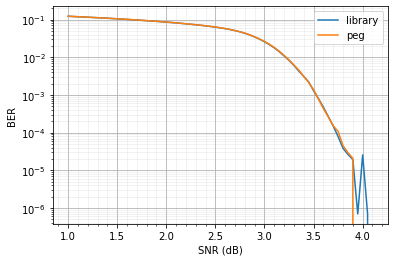

In [4]:
# regular rate 2/3 different construction methods
snr_library, ber_library = read_snr_ber_from_file("data/regular_library_2000_666_3")
snr_peg, ber_peg = read_snr_ber_from_file("data/regular_peg_2000_666_3")

plt.plot(snr_library, ber_library)
plt.plot(snr_peg, ber_peg)
plt.legend(['library','peg'])
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(which='major')
plt.grid(which='minor',axis='both',alpha=0.2)
plt.minorticks_on()
plt.yscale('log')
plt.savefig('plots/regular_rate_2_3_constructions.png',bbox_inches='tight')

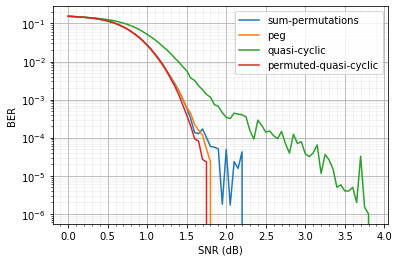

In [14]:
# protograph AR4JA rate 1/2 different construction methods
snr_sum_permutations, ber_sum_permutations = read_snr_ber_from_file("data/protograph_ar4ja_n_0_rate_1_2_sum-permutations_500")
snr_peg, ber_peg = read_snr_ber_from_file("data/protograph_ar4ja_n_0_rate_1_2_peg_500")
snr_quasi_cyclic, ber_quasi_cyclic = read_snr_ber_from_file("data/protograph_ar4ja_n_0_rate_1_2_quasi-cyclic_500")
snr_permuted_quasi_cyclic, ber_permuted_quasi_cyclic =\
        read_snr_ber_from_file("data/protograph_ar4ja_n_0_rate_1_2_permuted-quasi-cyclic_500")

plt.plot(snr_sum_permutations, ber_sum_permutations)
plt.plot(snr_peg, ber_peg)
plt.plot(snr_quasi_cyclic, ber_quasi_cyclic)
plt.plot(snr_permuted_quasi_cyclic, ber_permuted_quasi_cyclic)
plt.legend(['sum-permutations','peg','quasi-cyclic','permuted-quasi-cyclic'])
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(which='major')
plt.grid(which='minor',axis='both',alpha=0.2)
plt.minorticks_on()
plt.yscale('log')
plt.savefig('plots/ar4ja_rate_1_2_constructions.png',bbox_inches='tight')

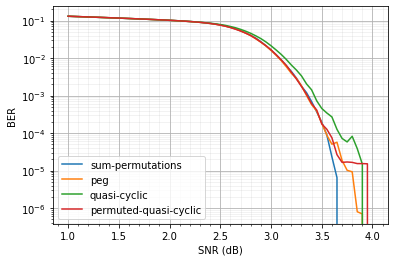

In [15]:
# protograph AR4JA rate 2/3 different construction methods
snr_sum_permutations, ber_sum_permutations = read_snr_ber_from_file("data/protograph_ar4ja_n_1_rate_2_3_sum-permutations_334")
snr_peg, ber_peg = read_snr_ber_from_file("data/protograph_ar4ja_n_1_rate_2_3_peg_334")
snr_quasi_cyclic, ber_quasi_cyclic = read_snr_ber_from_file("data/protograph_ar4ja_n_1_rate_2_3_quasi-cyclic_334")
snr_permuted_quasi_cyclic, ber_permuted_quasi_cyclic =\
        read_snr_ber_from_file("data/protograph_ar4ja_n_1_rate_2_3_permuted-quasi-cyclic_334")

plt.plot(snr_sum_permutations, ber_sum_permutations)
plt.plot(snr_peg, ber_peg)
plt.plot(snr_quasi_cyclic, ber_quasi_cyclic)
plt.plot(snr_permuted_quasi_cyclic, ber_permuted_quasi_cyclic)
plt.legend(['sum-permutations','peg','quasi-cyclic','permuted-quasi-cyclic'])
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(which='major')
plt.grid(which='minor',axis='both',alpha=0.2)
plt.minorticks_on()
plt.yscale('log')
plt.savefig('plots/ar4ja_rate_2_3_constructions.png',bbox_inches='tight')

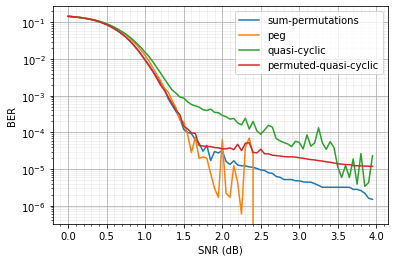

In [16]:
# protograph AR3A rate 1/2 different construction methods
snr_sum_permutations, ber_sum_permutations = read_snr_ber_from_file("data/protograph_ar3a_n_0_rate_1_2_sum-permutations_500")
snr_peg, ber_peg = read_snr_ber_from_file("data/protograph_ar3a_n_0_rate_1_2_peg_500")
snr_quasi_cyclic, ber_quasi_cyclic = read_snr_ber_from_file("data/protograph_ar3a_n_0_rate_1_2_quasi-cyclic_500")
snr_permuted_quasi_cyclic, ber_permuted_quasi_cyclic =\
        read_snr_ber_from_file("data/protograph_ar3a_n_0_rate_1_2_permuted-quasi-cyclic_500")

plt.plot(snr_sum_permutations, ber_sum_permutations)
plt.plot(snr_peg, ber_peg)
plt.plot(snr_quasi_cyclic, ber_quasi_cyclic)
plt.plot(snr_permuted_quasi_cyclic, ber_permuted_quasi_cyclic)
plt.legend(['sum-permutations','peg','quasi-cyclic','permuted-quasi-cyclic'])
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(which='major')
plt.grid(which='minor',axis='both',alpha=0.2)
plt.minorticks_on()
plt.yscale('log')
plt.savefig('plots/ar3a_rate_1_2_constructions.png',bbox_inches='tight')

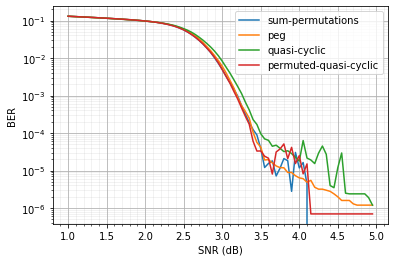

In [17]:
# protograph AR3A rate 2/3 different construction methods
snr_sum_permutations, ber_sum_permutations = read_snr_ber_from_file("data/protograph_ar3a_n_1_rate_2_3_sum-permutations_334")
snr_peg, ber_peg = read_snr_ber_from_file("data/protograph_ar3a_n_1_rate_2_3_peg_334")
snr_quasi_cyclic, ber_quasi_cyclic = read_snr_ber_from_file("data/protograph_ar3a_n_1_rate_2_3_quasi-cyclic_334")
snr_permuted_quasi_cyclic, ber_permuted_quasi_cyclic =\
        read_snr_ber_from_file("data/protograph_ar3a_n_1_rate_2_3_permuted-quasi-cyclic_334")

plt.plot(snr_sum_permutations, ber_sum_permutations)
plt.plot(snr_peg, ber_peg)
plt.plot(snr_quasi_cyclic, ber_quasi_cyclic)
plt.plot(snr_permuted_quasi_cyclic, ber_permuted_quasi_cyclic)
plt.legend(['sum-permutations','peg','quasi-cyclic','permuted-quasi-cyclic'])
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(which='major')
plt.grid(which='minor',axis='both',alpha=0.2)
plt.minorticks_on()
plt.yscale('log')
plt.savefig('plots/ar3a_rate_2_3_constructions.png',bbox_inches='tight')

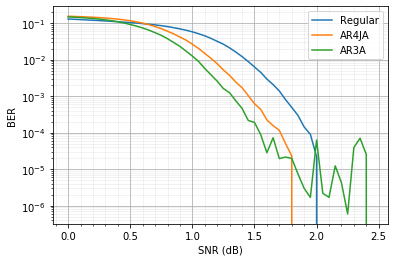

In [10]:
# rate 1/2 different codes comparison (best construction for each)
snr_regular, ber_regular = read_snr_ber_from_file("data/regular_peg_2000_1000_3")
snr_ar4ja, ber_ar4ja = read_snr_ber_from_file("data/protograph_ar4ja_n_0_rate_1_2_peg_500")
snr_ar3a, ber_ar3a = read_snr_ber_from_file("data/protograph_ar3a_n_0_rate_1_2_peg_500")

plt.plot(snr_regular, ber_regular)
plt.plot(snr_ar4ja, ber_ar4ja)
plt.plot(snr_ar3a, ber_ar3a)
plt.legend(['Regular','AR4JA','AR3A'])
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(which='major')
plt.grid(which='minor',axis='both',alpha=0.2)
plt.minorticks_on()
plt.yscale('log')
plt.savefig('plots/rate_1_2_comparison.png',bbox_inches='tight')

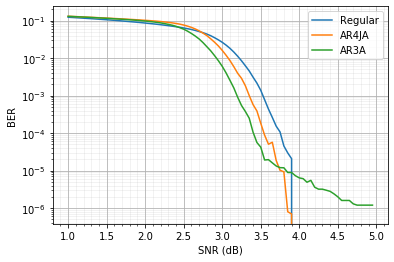

In [11]:
# rate 2/3 different codes comparison (best construction for each)
snr_regular, ber_regular = read_snr_ber_from_file("data/regular_peg_2000_666_3")
snr_ar4ja, ber_ar4ja = read_snr_ber_from_file("data/protograph_ar4ja_n_1_rate_2_3_peg_334")
snr_ar3a, ber_ar3a = read_snr_ber_from_file("data/protograph_ar3a_n_1_rate_2_3_peg_334")

plt.plot(snr_regular, ber_regular)
plt.plot(snr_ar4ja, ber_ar4ja)
plt.plot(snr_ar3a, ber_ar3a)
plt.legend(['Regular','AR4JA','AR3A'])
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.grid(which='major')
plt.grid(which='minor',axis='both',alpha=0.2)
plt.minorticks_on()
plt.yscale('log')
plt.savefig('plots/rate_2_3_comparison.png',bbox_inches='tight')